In [1]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')

%env WORKDIR=/Users/jitang/Dev/workdir

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import cartopy.crs as ccrs

from lib.reanalysis import r1
from lib import obs
from lib.plotting import maps
from lib.enso import oni_trimonthly

env: WORKDIR=/Users/jitang/Dev/workdir


In [266]:
sfo = obs.daily_summary('SFO', '1980-07-01', '2021-06-01')
sfo.loc[sfo.day == '2008-01-03', 'precip_in'] = 0.17
sfo.loc[sfo.day == '2008-01-04', 'precip_in'] = 2.10
sfo.loc[sfo.day == '2008-01-05', 'precip_in'] = 0.77
sfo.loc[sfo.precip_in < 0.1, 'precip_in'] = 0

data_cols = ['day', 'precip_in', 'max_temp_f', 'min_temp_f']

sfo_monthly = sfo[data_cols].resample('MS', on='day').agg({
    'precip_in': np.sum,
    'max_temp_f': np.mean,
    'min_temp_f': np.mean
}).reset_index()

djf = sfo_monthly[sfo_monthly.day.dt.month.isin([11, 12, 1, 2, 3])]

In [267]:
djf.precip_in.describe()

count    205.000000
mean       3.126049
std        2.641378
min        0.000000
25%        1.120000
50%        2.360000
75%        4.790000
max       13.520000
Name: precip_in, dtype: float64

In [318]:
wet_top50 = djf[djf.precip_in > djf.precip_in.mean() + 0.5*djf.precip_in.std()]
wet_top50.shape

# wet_top50 = djf.sort_values(by='precip_in', ascending=False).head(50)

(56, 4)

In [319]:
oni = oni_trimonthly()
wet_top50['month'] = wet_top50.day.dt.month
wet_top50['year'] = wet_top50.day.dt.year

oni_relevant = oni[['ANOM', 'MONTH', 'YR']]
oni_relevant.columns = ['ONI', 'month', 'year']
wet_top50 = wet_top50.merge(oni_relevant)

<ipython-input-319-7928ef441ab0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_top50['month'] = wet_top50.day.dt.month
<ipython-input-319-7928ef441ab0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_top50['year'] = wet_top50.day.dt.year


In [320]:
bbox = (0, 360, 90, 10)
_, _, wet_anoms = r1.hgt_monthly(500, yearmonths=wet_top50.day, bbox=bbox)

In [321]:
solver = Eof(wet_anoms.hgt)

# retrieve the first two EOFs from the solver class
eofs = solver.eofs(neofs=3)

In [322]:
solver.varianceFraction(neigs=3)

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.2626772 , 0.13898434, 0.11578579], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions

In [305]:
def plot_nhem_anoms(da, cmap, levels, title, draw=True, colorbar_label='Geopotential height anomaly (dm)'):
    proj = ccrs.NorthPolarStereo(central_longitude=-94.5, true_scale_latitude=None, globe=None)
    m = maps.CartopyMap(proj=proj)
    if draw:
        m.draw()
    m.plot.fill(da, cmap, levels, colorbar=True, colorbar_label=colorbar_label)
    m.textbox.bottom_right(title, fontsize=20)
    m.textbox.top_left('by Jim Tang (@wxmann)', fontsize=16)
    return m

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


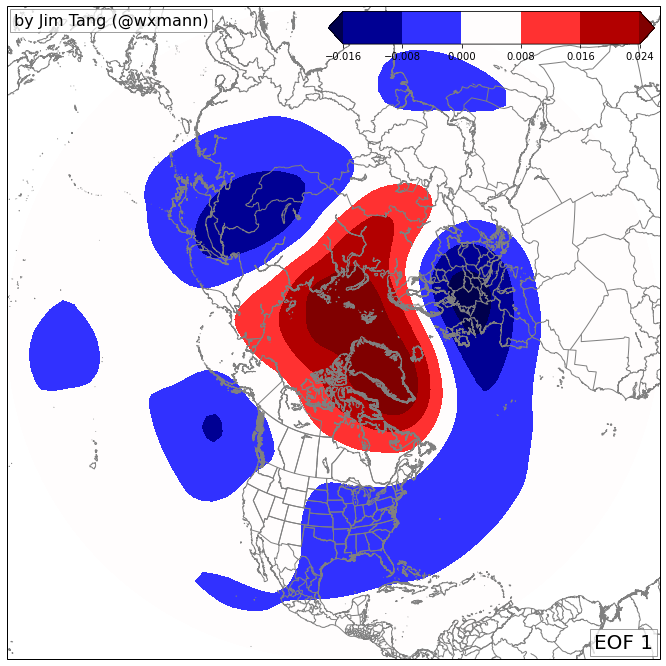

In [323]:
fig = plt.figure(figsize=(12, 12))

da = eofs[0]
cmap = 'seismic'
title = 'EOF 1'

m = plot_nhem_anoms(da, cmap, levels=None, title=title, draw=True, colorbar_label=None)

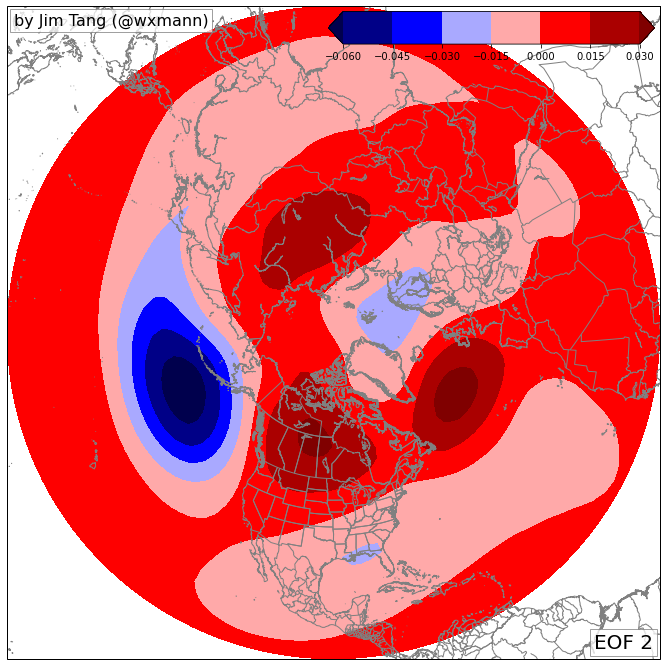

In [324]:
fig = plt.figure(figsize=(12, 12))

da = eofs[1]
cmap = 'seismic'
title = 'EOF 2'

m = plot_nhem_anoms(da, cmap, levels=None, title=title, draw=True, colorbar_label=None)

In [325]:
pcs = solver.pcs(pcscaling=1, npcs=2).to_dataframe().reset_index()
first_pc = pcs[pcs['mode'] == 0]
second_pc = pcs[pcs['mode'] == 1]
wet_with_pcs = wet_top50.merge(
    first_pc[['time', 'pcs']], left_on='day', right_on='time').merge(
    second_pc[['time', 'pcs']], on='time')

wet_with_pcs = wet_with_pcs.rename(columns={
    'pcs_x': 'pc1',
    'pcs_y': 'pc2'
})

In [326]:
wet_with_pcs

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
0,1981-01-01,5.72,56.612903,45.451613,1,1981,-0.26,1981-01-01,-0.961233,2.653318
1,1981-11-01,4.55,61.566667,51.200000,11,1981,-0.15,1981-11-01,0.206415,1.011947
2,1982-01-01,8.80,51.161290,38.967742,1,1982,-0.05,1982-01-01,0.289756,-0.878572
3,1982-03-01,7.49,56.935484,45.451613,3,1982,0.19,1982-03-01,-0.331494,-1.292040
4,1982-11-01,5.25,58.200000,46.566667,11,1982,2.18,1982-11-01,0.038761,-0.077695
5,1983-01-01,6.75,53.548387,42.870968,1,1983,2.18,1983-01-01,-0.727622,1.261543
6,1983-02-01,6.55,58.321429,48.285714,2,1983,1.92,1983-02-01,-0.290903,1.744385
7,1983-03-01,8.26,59.000000,49.193548,3,1983,1.54,1983-03-01,0.460284,1.618958
8,1983-11-01,5.97,60.966667,49.766667,11,1983,-1.00,1983-11-01,-0.601626,1.409164
9,1983-12-01,6.03,57.258065,49.548387,12,1983,-0.91,1983-12-01,-0.197557,0.190338


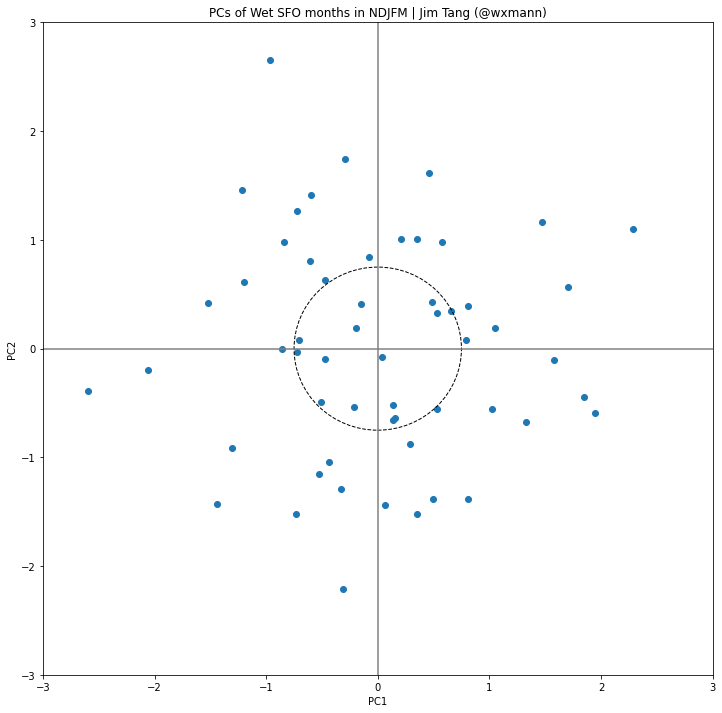

In [412]:
plt.figure(figsize=(12, 12))
plt.scatter(wet_with_pcs.pc1, wet_with_pcs.pc2)
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCs of Wet SFO months in NDJFM | Jim Tang (@wxmann)')
circ = plt.Circle((0, 0), 0.75, color='k', fill=False, ls='--')
plt.gca().add_patch(circ)

In [402]:
min_amplitude = 0.75
cod = wet_with_pcs.pc1 ** 2 + wet_with_pcs.pc2 ** 2 < min_amplitude ** 2
threshold = 0

q1 = wet_with_pcs[(wet_with_pcs.pc1 > threshold) & (wet_with_pcs.pc2 > threshold) & ~cod]
_, _, q1_anoms = r1.hgt_monthly(500, yearmonths=q1.day, bbox=bbox)

q2 = wet_with_pcs[(wet_with_pcs.pc1 < -threshold) & (wet_with_pcs.pc2 > threshold) & ~cod]
_, _, q2_anoms = r1.hgt_monthly(500, yearmonths=q2.day, bbox=bbox)

q3 = wet_with_pcs[(wet_with_pcs.pc1 < -threshold) & (wet_with_pcs.pc2 < -threshold) & ~cod]
_, _, q3_anoms = r1.hgt_monthly(500, yearmonths=q3.day, bbox=bbox)

q4 = wet_with_pcs[(wet_with_pcs.pc1 > threshold) & (wet_with_pcs.pc2 < -threshold) & ~cod]
_, _, q4_anoms = r1.hgt_monthly(500, yearmonths=q4.day, bbox=bbox)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


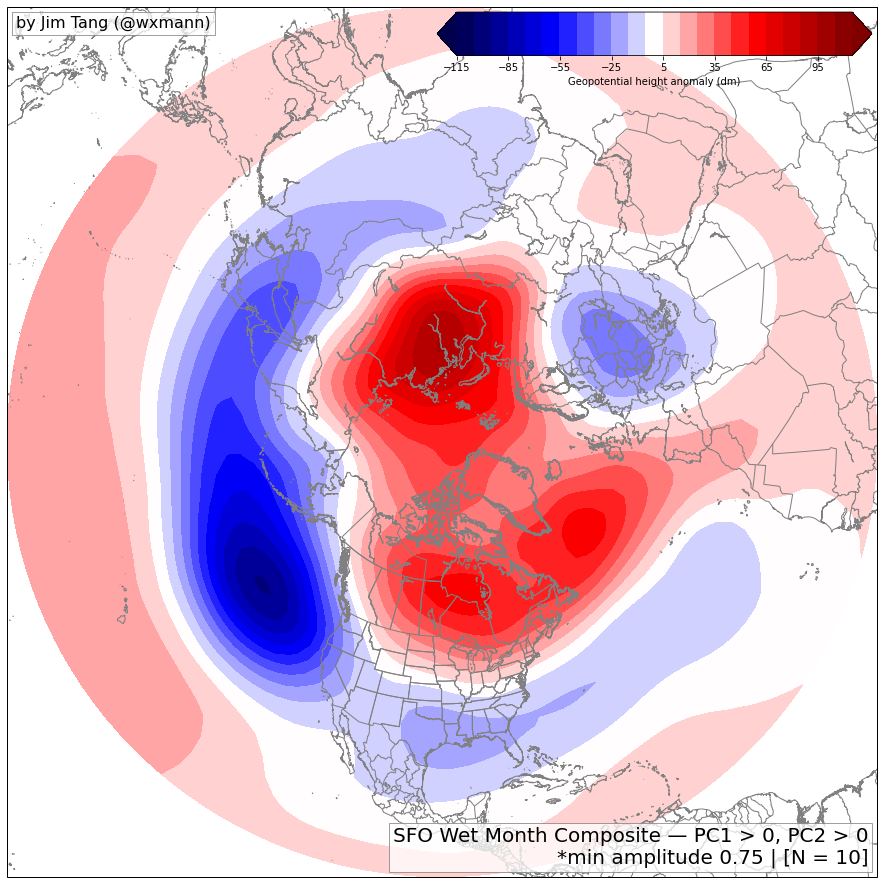

In [408]:
fig = plt.figure(figsize=(16, 16))

da = q1_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC1 > 0, PC2 > 0\n*min amplitude {min_amplitude} | [N = {len(q1_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


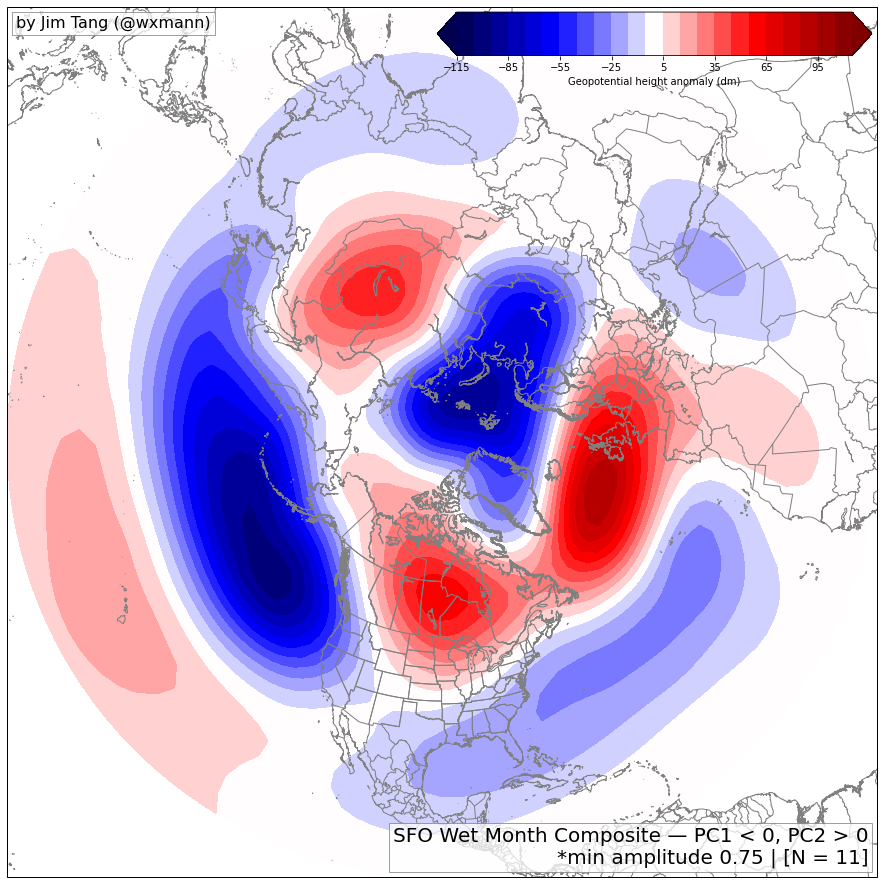

In [409]:
fig = plt.figure(figsize=(16, 16))

da = q2_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC1 < 0, PC2 > 0\n*min amplitude {min_amplitude} | [N = {len(q2_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


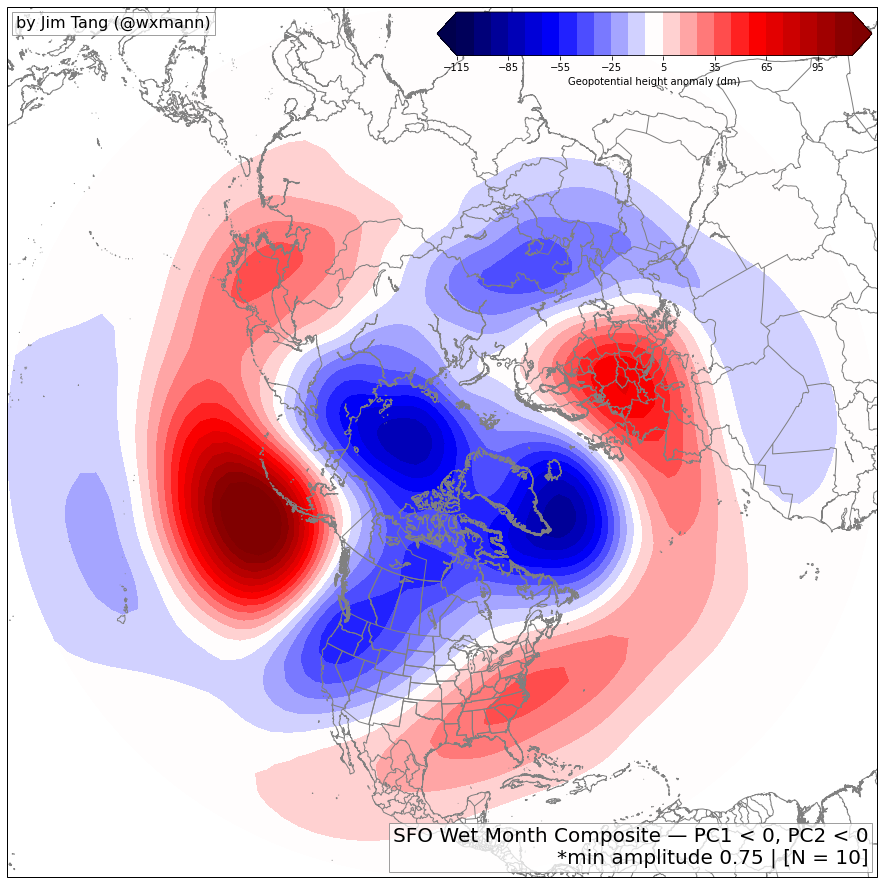

In [410]:
fig = plt.figure(figsize=(16, 16))

da = q3_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC1 < 0, PC2 < 0\n*min amplitude {min_amplitude} | [N = {len(q3_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


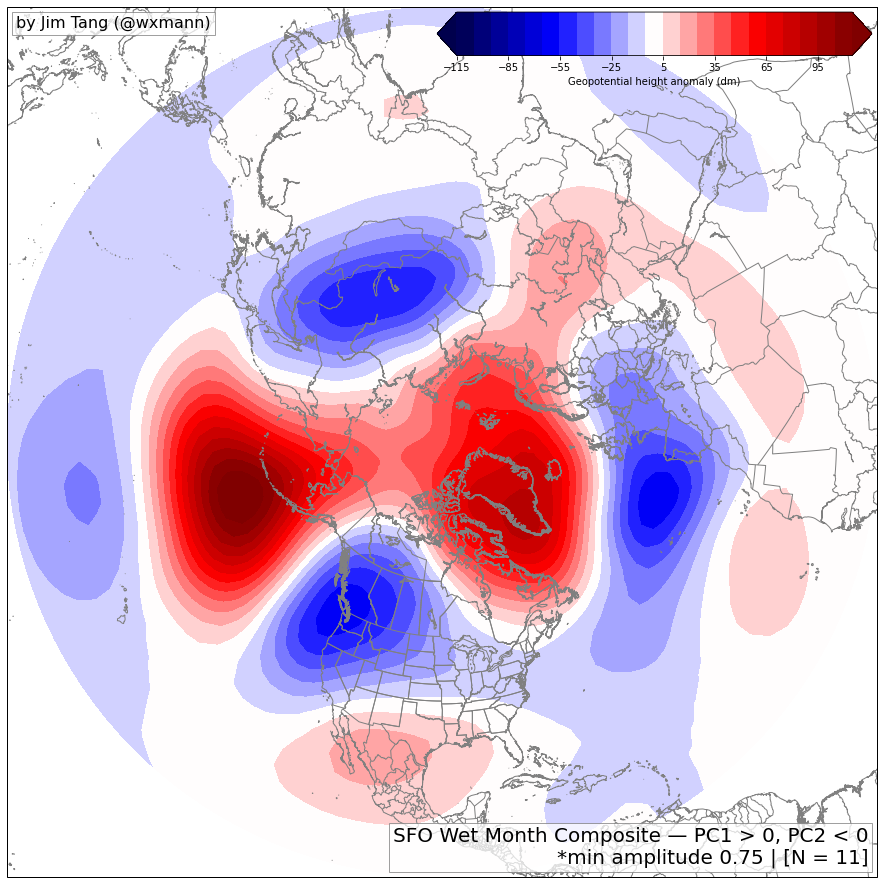

In [411]:
fig = plt.figure(figsize=(16, 16))

da = q4_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC1 > 0, PC2 < 0\n*min amplitude {min_amplitude} | [N = {len(q4_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x149660c40>,
 'caps': [<matplotlib.lines.Line2D at 0x149641430>,
 'boxes': [<matplotlib.lines.Line2D at 0x149660970>,
 'medians': [<matplotlib.lines.Line2D at 0x15cf44a00>,
 'fliers': [<matplotlib.lines.Line2D at 0x15cf44340>,
 'means': []}

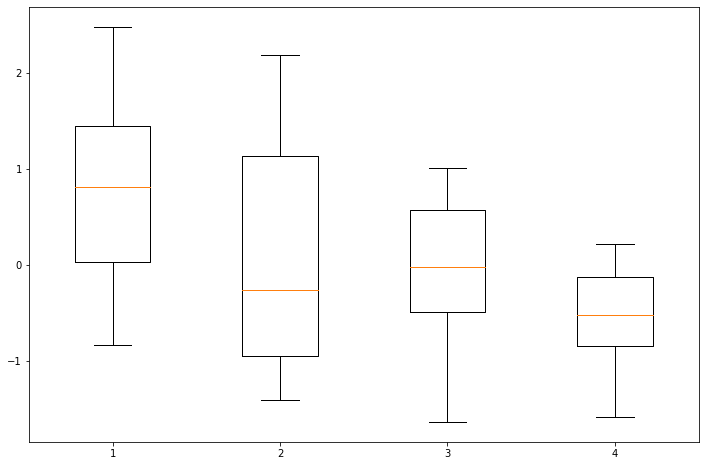

In [415]:
plt.figure(figsize=(12, 8))
plt.boxplot([q1.ONI, q2.ONI, q3.ONI, q4.ONI])

In [416]:
q1

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
1,1981-11-01,4.55,61.566667,51.200000,11,1981,-0.15,1981-11-01,0.206415,1.011947
7,1983-03-01,8.26,59.000000,49.193548,3,1983,1.54,1983-03-01,0.460284,1.618958
20,1995-01-01,8.76,56.064516,48.419355,1,1995,0.96,1995-01-01,0.572520,0.978273
28,1998-01-01,7.77,57.290323,48.516129,1,1998,2.24,1998-01-01,1.708413,0.562656
33,2001-12-01,8.27,56.032258,47.258065,12,2001,-0.31,2001-12-01,0.804312,0.395861
34,2002-12-01,9.37,57.774194,47.612903,12,2002,1.14,2002-12-01,0.786361,0.076673
37,2005-02-01,4.82,60.357143,49.571429,2,2005,0.58,2005-02-01,1.046904,0.186028
38,2005-12-01,8.17,59.032258,47.870968,12,2005,-0.84,2005-12-01,1.467424,1.166818
48,2014-12-01,10.47,61.580645,51.935484,12,2014,0.66,2014-12-01,0.355801,1.009804
49,2016-01-01,5.31,57.000000,48.387097,1,2016,2.48,2016-01-01,2.285636,1.099023


In [417]:
q2

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
0,1981-01-01,5.72,56.612903,45.451613,1,1981,-0.26,1981-01-01,-0.961233,2.653318
5,1983-01-01,6.75,53.548387,42.870968,1,1983,2.18,1983-01-01,-0.727622,1.261543
6,1983-02-01,6.55,58.321429,48.285714,2,1983,1.92,1983-02-01,-0.290903,1.744385
8,1983-11-01,5.97,60.966667,49.766667,11,1983,-1.00,1983-11-01,-0.601626,1.409164
17,1993-02-01,4.54,58.107143,47.071429,2,1993,0.30,1993-02-01,-0.840503,0.976503
22,1995-12-01,6.27,58.580645,48.806452,12,1995,-0.98,1995-12-01,-0.476277,0.632895
26,1997-01-01,7.35,55.129032,46.322581,1,1997,-0.50,1997-01-01,-1.517182,0.421353
29,1998-02-01,13.52,56.714286,47.750000,2,1998,1.93,1998-02-01,-1.218280,1.461244
31,2000-02-01,8.15,57.827586,48.793103,2,2000,-1.41,2000-02-01,-0.079715,0.838666
35,2003-12-01,6.09,56.903226,46.870968,12,2003,0.35,2003-12-01,-0.609834,0.808585


In [418]:
q3

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
3,1982-03-01,7.49,56.935484,45.451613,3,1982,0.19,1982-03-01,-0.331494,-1.292040
12,1986-03-01,5.83,63.774194,50.225806,3,1986,-0.31,1986-03-01,-2.057446,-0.200810
15,1992-12-01,5.92,55.193548,44.064516,12,1992,-0.13,1992-12-01,-1.304432,-0.914075
16,1993-01-01,11.07,55.225806,42.967742,1,1993,0.09,1993-01-01,-2.595051,-0.388171
19,1994-11-01,5.45,56.100000,44.100000,11,1994,1.01,1994-11-01,-1.438845,-1.432415
36,2004-12-01,6.26,58.000000,46.290323,12,2004,0.69,2004-12-01,-0.862026,-0.001049
40,2008-01-01,9.87,53.036774,43.682581,1,2008,-1.64,2008-01-01,-0.437907,-1.044053
44,2011-02-01,4.79,58.178571,43.000000,2,2011,-1.19,2011-02-01,-0.310956,-2.208697
51,2016-12-01,4.51,56.677419,42.161290,12,2016,-0.56,2016-12-01,-0.523125,-1.154891
55,2019-02-01,7.20,55.892857,44.071429,2,2019,0.72,2019-02-01,-0.729635,-1.520384


In [419]:
q4

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
2,1982-01-01,8.80,51.161290,38.967742,1,1982,-0.05,1982-01-01,0.289756,-0.878572
13,1991-03-01,5.96,57.741935,46.580645,3,1991,0.22,1991-03-01,0.490934,-1.387173
18,1994-02-01,5.12,56.535714,44.464286,2,1994,0.07,1994-02-01,0.063166,-1.434261
23,1996-01-01,6.84,57.064516,46.580645,1,1996,-0.90,1996-01-01,0.349650,-1.518013
25,1996-12-01,6.49,58.870968,49.290323,12,1996,-0.49,1996-12-01,1.024800,-0.554527
32,2001-02-01,5.98,56.428571,45.035714,2,2001,-0.52,2001-02-01,0.531007,-0.555372
39,2006-03-01,5.63,56.935484,43.806452,3,2006,-0.57,2006-03-01,1.945098,-0.595624
41,2009-02-01,6.24,58.107143,46.035714,2,2009,-0.79,2009-02-01,0.807314,-1.384276
43,2010-12-01,5.80,56.709677,47.483871,12,2010,-1.59,2010-12-01,1.845159,-0.441670
47,2012-12-01,6.23,57.290323,46.387097,12,2012,-0.21,2012-12-01,1.326676,-0.678430
